In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE, mutual_info_classif, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import itertools

from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [2]:
df = pd.read_csv(
    "../datasets/breast_cancer.csv", 
    usecols = [
        "radius_mean", "texture_mean", "perimeter_mean", "area_mean", 
        "smoothness_mean", "compactness_mean", "concavity_mean", 
        "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
        "diagnosis" 
    ]
)

df.rename(columns={
    "radius_mean": "radius",
    "texture_mean": "texture",
    "perimeter_mean": "perimeter",
    "area_mean": "area",
    "smoothness_mean": "smoothness",
    "compactness_mean": "compactness",
    "concavity_mean": "concavity",
    "concave points_mean": "concave_points",
    "symmetry_mean": "symmetry",
    "fractal_dimension_mean": "fractal_dimension",
    "diagnosis": "diagnosis"
}, inplace = True)

df['diagnosis'].replace({
    "M": 1,  
    "B": 0   
}, inplace = True)

df_filtered = df[df['diagnosis'].isin([0, 1])]

num_rows = len(df_filtered)

if num_rows >= 1000:
    df_sample = df_filtered.sample(n = 1000, random_state = 42)
else:
    df_sample = df_filtered

df_sample.head()

C:\Users\msala\AppData\Local\Temp\ipykernel_16196\2501444660.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['diagnosis'].replace({
C:\Users\msala\AppData\Local\Temp\ipykernel_16196\2501444660.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'].replace({


,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [3]:
X = df_sample[[
    "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", 
    "concave_points", "symmetry", "fractal_dimension"
]] 

y = df_sample['diagnosis']

corr_matrix = X.corr()

target_corr = df_sample.corr()['diagnosis']

C:\Users\msala\AppData\Local\Temp\ipykernel_16196\2700000468.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


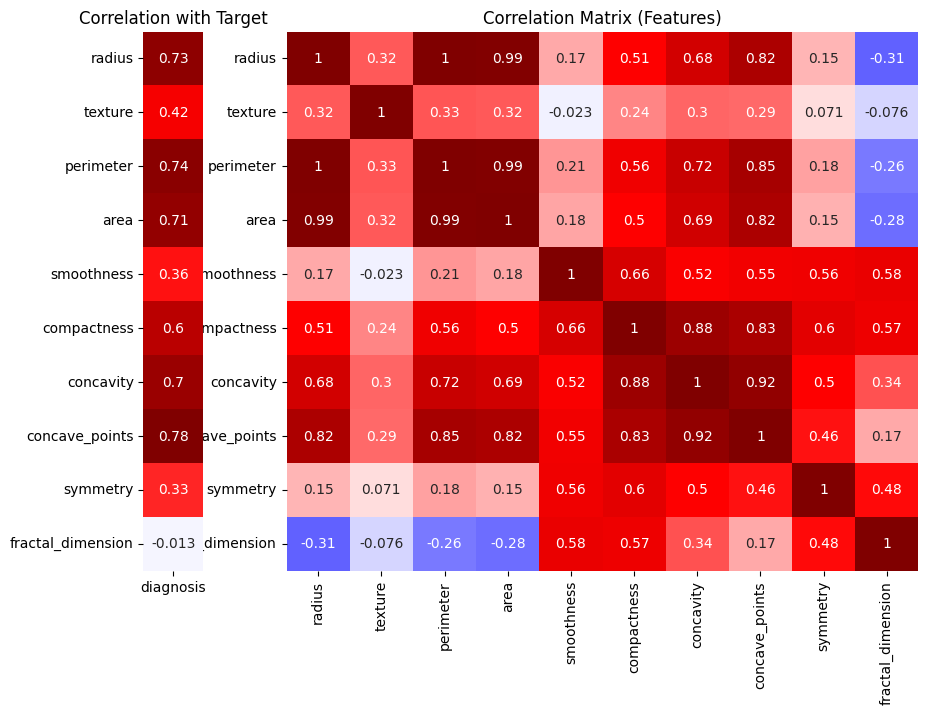

In [4]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 11, (3, 11))  
sns.heatmap(corr_matrix, annot=True, cmap='seismic', cbar=False, ax=ax1, center=0)
ax1.set_title('Correlation Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 11, 1)  
sns.heatmap(target_corr.drop('diagnosis').to_frame(), annot=True, cmap='seismic', cbar=False, ax=ax2, center=0)
ax2.set_title('Correlation with Target', fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
def split_features_target(df, target_column):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    return X, y

In [6]:
def train_test_split_scaled(X, y, test_size=0.3, random_state=42, scale=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Normalizing the data
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## Lasso

In [7]:
# Set feature variable and target variable
#X, y = split_features_target(df_sample, "diagnosis")

#print(X.shape) 
#print(y.shape)

Training the dataset and defining the regression type:

In [8]:
# Splitting the dataset into training and testing
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split_scaled(X, y, test_size=0.3, random_state=42)

In [9]:
# Applying LASSO
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.5) 
lasso_model.fit(X_train, y_train)

y_proba_lasso = lasso_model.predict_proba(X_test)[:, 1]

coef = pd.Series(lasso_model.coef_[0], index=X.columns)
selected_features = coef[coef != 0]
print("Features selected by LASSO:\n")
print(selected_features)

Features selected by LASSO:

texture              1.082201
area                 2.115962
smoothness           0.333633
concave_points       2.854686
symmetry             0.230397
fractal_dimension   -0.167884
dtype: float64


In [10]:
# Model evaluation
y_pred = lasso_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9415204678362573


In [11]:
# Calculate AUROC
auroc_lasso = roc_auc_score(y_test, y_proba_lasso)
print(f"AUROC of model: {auroc_lasso}")

AUROC of model: 0.9910346854791299


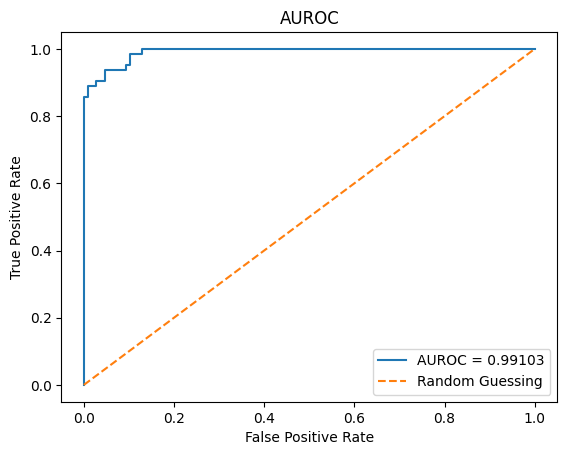

In [12]:
#Plot the graph
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lasso)
plt.plot(fpr, tpr, label=f'AUROC = {auroc_lasso:.5f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC')
plt.legend()
plt.show()

## RFE

In [13]:
#X, y = split_features_target(df_sample, "diagnosis")

#print(X.shape) 
#print(y.shape)

In [14]:
# Splitting the dataset into training and testing
rfe = RFE(model)

rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Features selected by RFE:\n")
print(selected_features)

Features selected by RFE:

Index(['radius', 'texture', 'area', 'smoothness', 'concave_points'], dtype='object')


In [15]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

model.fit(X_train_rfe, y_train)

# Model evaluation
accuracy = model.score(X_test_rfe, y_test)
print(f"Model Accuracy [RFE]: {accuracy}")

Model Accuracy [RFE]: 0.9415204678362573


In [16]:
X_test_rfe = rfe.transform(X_test)
y_proba_rfe = model.predict_proba(X_test_rfe)[:, 1] 

#Calculete AUROC
auroc_rfe = roc_auc_score(y_test, y_proba_rfe)
print(f"AUROC of model RFE: {auroc_rfe}")

AUROC of model RFE: 0.9914756025867137


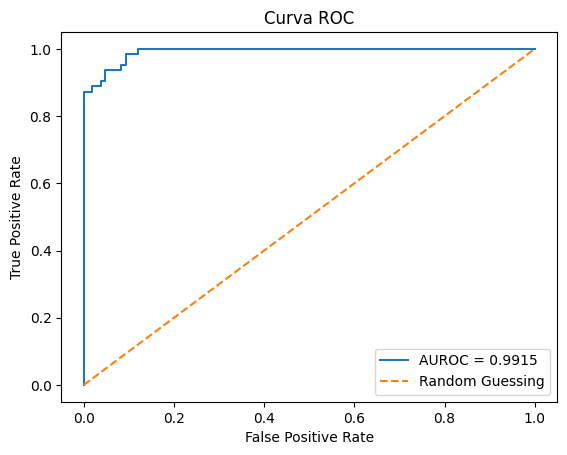

In [17]:
#Plot the graph
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rfe)
plt.plot(fpr, tpr, label=f'AUROC = {auroc_rfe:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Optimum

In [18]:
#X = df_sample.drop(columns=['diagnosis'])  # Features
#y = df_sample['diagnosis']  # Target

In [19]:
# Function to calculate the sum of correlations with the target
def sumFeatureTarget(z, target_corr):
    sum_value = 0
    for i in range(len(z)):
        sum_value += z[i] * abs(float(target_corr.iloc[i]))
    return sum_value

# Function to calculate the sum of correlations between features
def sumFeatureFeature(z, corr_matrix):
    sum_value = 0
    for i in range(len(z)):
        for j in range(len(z)):
            if i != j:
                sum_value += z[i] * z[j] * abs(float(corr_matrix.iloc[i, j]))
    return sum_value

In [20]:
# Brute force function to select best features
def brute_force(phi, combinations, target_corr, corr_matrix):
    min_value = float('inf')
    best_features = []
    
    for combination in combinations:
        h = -((phi * sumFeatureTarget(combination, target_corr)) - ((1 - phi) * sumFeatureFeature(combination, corr_matrix)))
        
        if h < min_value:
            min_value = h
            best_features = combination
    
    # Returns the index of the selected features
    selected_features = [i for i, val in enumerate(best_features) if val == 1]
    return selected_features

In [21]:
# Generate combinations of features
combinations = list(itertools.product([0, 1], repeat=10)) 
combinations = np.array(combinations)

combinations = combinations[1:] 
mask = np.sum(combinations, axis=1) >= 5
combinations = combinations[mask]

In [22]:
# Correlation matrix with the target (target_corr) and between the features (corr_matrix)
target_corr = X.corrwith(y) 
corr_matrix = X.corr()

phi = 0.75

best_features= brute_force(phi, combinations, target_corr, corr_matrix)

print(f"Best Features): {best_features}")

Best Features): [0, 1, 3, 4, 8]


In [23]:
# Name of the best features
feature_names = X.columns
selected_feature_names = feature_names[best_features]
print(f"Name of the best features:\n{selected_feature_names}")

Name of the best features:
Index(['radius', 'texture', 'area', 'smoothness', 'symmetry'], dtype='object')


In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_predm = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Acuracy of Model: {accuracy:.6f}")

Acuracy of Model: 0.941520


In [25]:
# Calculate AUROC
y_scores = model.predict_proba(X_test)[:, 1]
optimum_auroc = roc_auc_score(y_test, y_scores)

print(f"AUROC of model Brute Force: {optimum_auroc:.6f}")

AUROC of model Brute Force: 0.992210


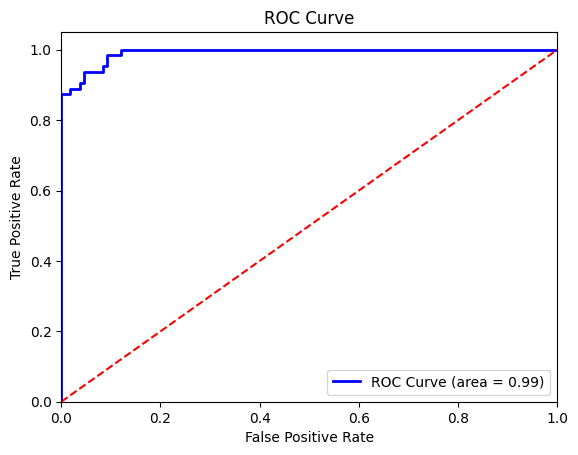

In [26]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(optimum_auroc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#  Mutual Information

Creating dependency measures between features and between the features and the target, using Mutual Information as the dependency measure.

In [27]:
def calculate_mi_matrix(X):
    n_features = X.shape[1]
    mi_matrix = pd.DataFrame(np.zeros((n_features, n_features)), index=X.columns, columns=X.columns)
    
    for i in range(n_features):
        for j in range(n_features):
            if i == j:
                mi_matrix.iloc[i, j] = 1
            else:
                mi_matrix.iloc[i, j] = mutual_info_regression(X.iloc[:, i].values.reshape(-1, 1), X.iloc[:, j])
    return mi_matrix

mi_matrix = calculate_mi_matrix(X)

mi_scores = mutual_info_classif(X, y, discrete_features=False)
target_mi = pd.Series(mi_scores, index=X.columns)
target_mi = target_mi.to_frame().rename(columns={0: 'diagnosis'})

C:\Users\msala\AppData\Local\Temp\ipykernel_16196\3076595409.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


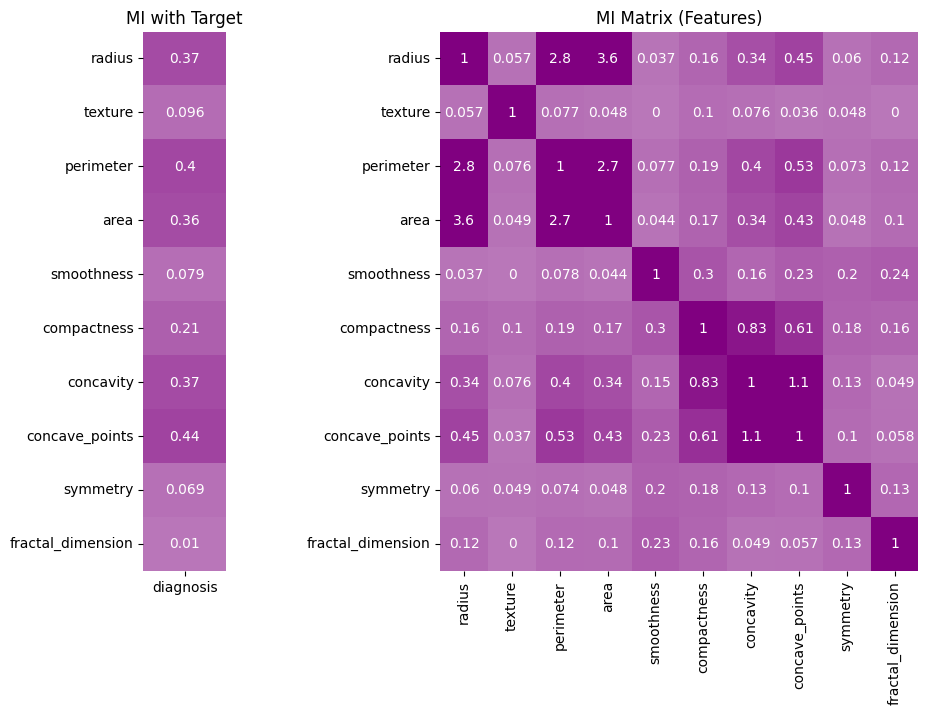

In [28]:
custom_palette = sns.light_palette("purple", as_cmap=True)  

plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 8, (4, 8))
sns.heatmap(mi_matrix, annot=True, cmap=custom_palette, cbar=False, ax=ax1, center=0, vmin=-1, vmax=1)
ax1.set_title('MI Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 8, 1)
sns.heatmap(target_mi, annot=True, cmap=custom_palette, cbar=False, ax=ax2, center=0, vmin=-1, vmax=1)
ax2.set_title('MI with Target', fontsize=12)

plt.tight_layout()
plt.show()

##### Creating dependency measures between the features and the target using AUC ROC as the dependency measure:

In [29]:
roc_scores = []

for feature in X.columns:
    try:
        roc = roc_auc_score(y, X[feature])
        roc_scores.append(roc)
    except ValueError:
        roc_scores.append(np.nan)

target_roc = pd.Series(roc_scores, index=X.columns)
target_roc = target_roc.to_frame().rename(columns={0: 'diagnosis'})

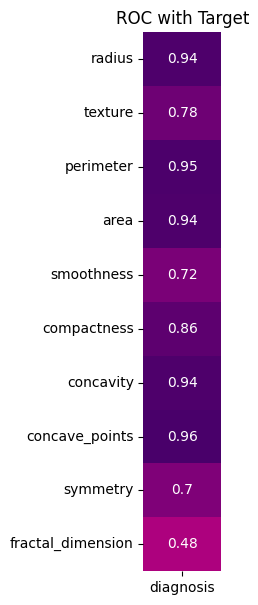

In [30]:
# Ploting the AUC ROC values between the features and the target
plt.figure(figsize=(1, 7))

sns.heatmap(target_roc, annot=True, cmap='RdPu', cbar=False, center=0)

plt.title('ROC with Target', fontsize=12)

plt.show()

In [31]:
def train_and_evaluate(X_train, y_train, X_test, y_test, features):
    X_train_subset = X_train[:, features]  
    X_test_subset = X_test[:, features]

    model.fit(X_train_subset, y_train)
    
    predictions = model.predict_proba(X_test_subset)[:, 1]
     
    auroc = roc_auc_score(y_test, predictions)
    return auroc

In [32]:
x_roc_correl = []
x_mi_mi = []
y_axis = []

for phi in np.arange(0, 1.1, 0.1):
    selected_features_roc_corr = brute_force(phi, combinations, target_roc, corr_matrix) # Using ROC and Correlation
    selected_features_mi_mi = brute_force(phi, combinations, target_mi, mi_matrix) # Using ROC and Mutual Information

    auroc_roc_corr = train_and_evaluate(X_train, y_train, X_test, y_test, selected_features_roc_corr)
    auroc_mi_mi = train_and_evaluate(X_train, y_train, X_test, y_test, selected_features_mi_mi)

    x_roc_correl.append(auroc_roc_corr)
    x_mi_mi.append(auroc_mi_mi)
    y_axis.append(phi)

C:\Users\msala\AppData\Local\Temp\ipykernel_16196\336186216.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sum_value += z[i] * abs(float(target_corr.iloc[i]))
C:\Users\msala\AppData\Local\Temp\ipykernel_16196\336186216.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sum_value += z[i] * abs(float(target_corr.iloc[i]))
C:\Users\msala\AppData\Local\Temp\ipykernel_16196\336186216.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sum_value += z[i] * abs(float(target_corr.iloc[i]))
C:\Users\msala\AppData\Local\Temp\ipykernel_16196\336186216.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  

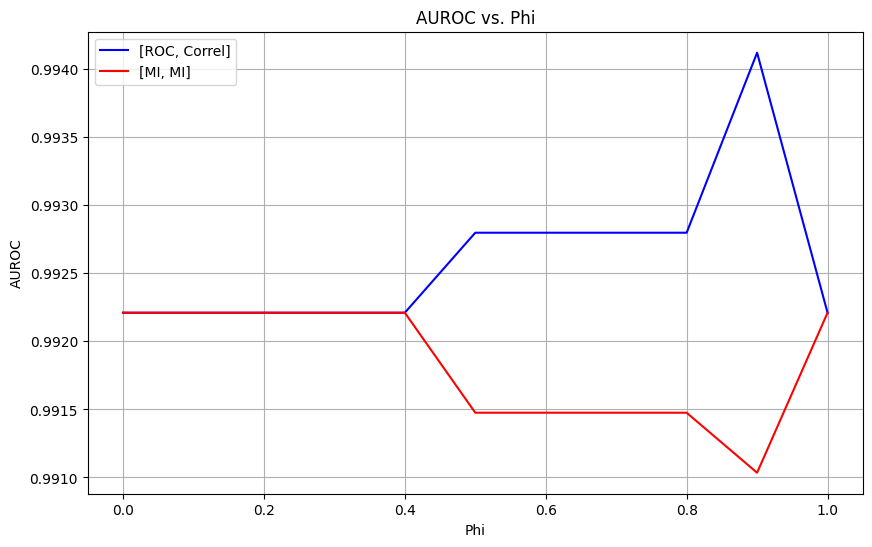

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_axis, x_roc_correl, linestyle='-', color='b', label='[ROC, Correl]')
plt.plot(y_axis, x_mi_mi, linestyle='-', color='r', label='[MI, MI]')

plt.title('AUROC vs. Phi')
plt.xlabel('Phi')
plt.ylabel('AUROC')
plt.legend()

plt.grid(True)
plt.show()

In [34]:
#Training a model with all the features
model.fit(X_train, y_train)

y_proba_all = model.predict_proba(X_test)[:, 1]

x_all = roc_auc_score(y_test, y_proba_all)
print(f"AUROC for all: {x_all}")

AUROC for all: 0.9922104644326866


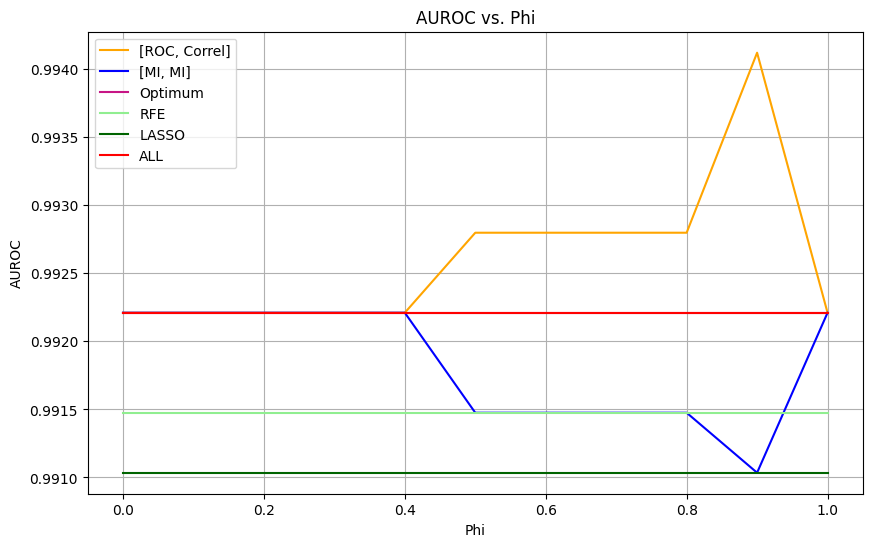

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(y_axis, x_roc_correl, linestyle='-', color='orange', label='[ROC, Correl]')
plt.plot(y_axis, x_mi_mi, linestyle='-', color='b', label='[MI, MI]')
plt.plot([0, 1], [optimum_auroc, optimum_auroc], color='#C71585', linestyle='-', label='Optimum') 
plt.plot([0, 1], [auroc_rfe, auroc_rfe], color='lightgreen', linestyle='-', label='RFE')
plt.plot([0, 1], [auroc_lasso, auroc_lasso], color='darkgreen', linestyle='-', label='LASSO')
plt.plot([0, 1], [x_all, x_all], color='r', linestyle='-', label='ALL')

plt.title('AUROC vs. Phi')
plt.xlabel('Phi')
plt.ylabel('AUROC')
plt.legend()

plt.grid(True)
plt.show()

In [50]:
X_qubo = df_sample[[
    "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", 
    "concave_points"
]] 

y_qubo = df_sample['diagnosis']

corr_matrix_qubo = np.cov(X_qubo.T)

target_corr_qubo = df_sample[[
    "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", 
    "concave_points"
]].corrwith(df_sample['diagnosis'])

print(corr_matrix_qubo)
print(target_corr_qubo)

[[ 1.24189201e+01  4.90758156e+00  8.54471417e+01  1.22448341e+03
   8.45445983e-03  9.41970568e-02  1.90127582e-01  1.12475116e-01]
 [ 4.90758156e+00  1.84989087e+01  3.44397592e+01  4.85993787e+02
  -1.41477877e-03  5.37668058e-02  1.03692344e-01  4.89769268e-02]
 [ 8.54471417e+01  3.44397592e+01  5.90440480e+02  8.43577235e+03
   7.08360652e-02  7.14714125e-01  1.38723362e+00  8.02360375e-01]
 [ 1.22448341e+03  4.85993787e+02  8.43577235e+03  1.23843554e+05
   8.76178126e-01  9.26493079e+00  1.92449238e+01  1.12419582e+01]
 [ 8.45445983e-03 -1.41477877e-03  7.08360652e-02  8.76178126e-01
   1.97799700e-04  4.89573915e-04  5.85242774e-04  3.02167060e-04]
 [ 9.41970568e-02  5.37668058e-02  7.14714125e-01  9.26493079e+00
   4.89573915e-04  2.78918740e-03  3.71813492e-03  1.70323279e-03]
 [ 1.90127582e-01  1.03692344e-01  1.38723362e+00  1.92449238e+01
   5.85242774e-04  3.71813492e-03  6.35524790e-03  2.85018988e-03]
 [ 1.12475116e-01  4.89769268e-02  8.02360375e-01  1.12419582e+01
   

In [43]:
mod = QuadraticProgram("my problem")


In [44]:
for i in range(len(target_corr_qubo)):
    mod.binary_var(name="x" + str(i + 1))
print(mod.prettyprint())

Problem name: my problem

Minimize
  0

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8



In [51]:
lin = target_corr_qubo.tolist()

In [58]:
def matrix_to_lists(matrix):
    n_lin, n_col = matrix.shape
    lists = []
    for i in range(n_lin):
        line = []
        for j in range(n_col):
            if i == j:
                line.append(0)
            else:
                line.append(matrix[i][j])
        lists.append(line)
    return lists

In [64]:
quad = corr_matrix_qubo

print(quad)

[[0, np.float64(4.907581563992921), np.float64(85.44714165573404), np.float64(1224.483409346457), np.float64(0.008454459829791577), np.float64(0.09419705682504516), np.float64(0.19012758202583513), np.float64(0.11247511634117184)], [np.float64(4.907581563992921), 0, np.float64(34.43975916668729), np.float64(485.9937866562292), np.float64(-0.0014147787742270867), np.float64(0.05376680580428971), np.float64(0.10369234400732999), np.float64(0.04897692677671476)], [np.float64(85.44714165573404), np.float64(34.43975916668729), 0, np.float64(8435.772345082802), np.float64(0.07083606523707268), np.float64(0.7147141250727121), np.float64(1.3872336152829214), np.float64(0.8023603752468812)], [np.float64(1224.483409346457), np.float64(485.9937866562292), np.float64(8435.772345082802), 0, np.float64(0.8761781263088194), np.float64(9.264930788911856), np.float64(19.24492382628181), np.float64(11.241958155817594)], [np.float64(0.008454459829791577), np.float64(-0.0014147787742270867), np.float64(0.

In [66]:
mod.minimize(constant=0, linear=lin, quadratic=quad)
print(mod.prettyprint())

Problem name: my problem

Minimize
  9.815163127985842*x1*x2 + 170.8942833114681*x1*x3 + 2448.966818692914*x1*x4
  + 0.016908919659583153*x1*x5 + 0.18839411365009032*x1*x6
  + 0.38025516405167026*x1*x7 + 0.22495023268234368*x1*x8
  + 68.87951833337458*x2*x3 + 971.9875733124584*x2*x4
  - 0.0028295575484541735*x2*x5 + 0.10753361160857942*x2*x6
  + 0.20738468801465998*x2*x7 + 0.09795385355342952*x2*x8
  + 16871.544690165603*x3*x4 + 0.14167213047414537*x3*x5
  + 1.4294282501454243*x3*x6 + 2.774467230565843*x3*x7
  + 1.6047207504937624*x3*x8 + 1.7523562526176388*x4*x5
  + 18.529861577823713*x4*x6 + 38.48984765256362*x4*x7
  + 22.483916311635188*x4*x8 + 0.0009791478304314461*x5*x6
  + 0.0011704855484488354*x5*x7 + 0.0006043341202347213*x5*x8
  + 0.00743626984356036*x6*x7 + 0.0034064655736912425*x6*x8
  + 0.005700379757704884*x7*x8 + 0.7300285113754558*x1 + 0.41518529984520386*x2
  + 0.7426355297258322*x3 + 0.7089838365853893*x4 + 0.35855996508593174*x5
  + 0.5965336775082526*x6 + 0.696359707

In [67]:
QuadraticProgramToQubo.get_compatibility_msg(mod)

''

In [70]:
qubo = QuadraticProgramToQubo().convert(mod)

print(qubo.prettyprint())

Problem name: my problem

Minimize
  9.815163127985842*x1*x2 + 170.8942833114681*x1*x3 + 2448.966818692914*x1*x4
  + 0.016908919659583153*x1*x5 + 0.18839411365009032*x1*x6
  + 0.38025516405167026*x1*x7 + 0.22495023268234368*x1*x8
  + 68.87951833337458*x2*x3 + 971.9875733124584*x2*x4
  - 0.0028295575484541735*x2*x5 + 0.10753361160857942*x2*x6
  + 0.20738468801465998*x2*x7 + 0.09795385355342952*x2*x8
  + 16871.544690165603*x3*x4 + 0.14167213047414537*x3*x5
  + 1.4294282501454243*x3*x6 + 2.774467230565843*x3*x7
  + 1.6047207504937624*x3*x8 + 1.7523562526176388*x4*x5
  + 18.529861577823713*x4*x6 + 38.48984765256362*x4*x7
  + 22.483916311635188*x4*x8 + 0.0009791478304314461*x5*x6
  + 0.0011704855484488354*x5*x7 + 0.0006043341202347213*x5*x8
  + 0.00743626984356036*x6*x7 + 0.0034064655736912425*x6*x8
  + 0.005700379757704884*x7*x8 + 0.7300285113754558*x1 + 0.41518529984520386*x2
  + 0.7426355297258322*x3 + 0.7089838365853893*x4 + 0.35855996508593174*x5
  + 0.5965336775082526*x6 + 0.696359707

In [73]:
hamiltonian, offset = qubo.to_ising()

print(hamiltonian)

SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-6.57986708e+02+0.j, -2.62980667e+02+0.j, -4.27968851e+03+0.j,
 -5.09379326e+03+0.j, -6.56995411e-01+0.j, -5.36502670e+00+0.j,
 -1.08147453e+01+0.j, -6.49362000e+00+0.j,  2.45379078e+00+0.j,
  4.27235708e+01+0.j,  6.12241705e+02+0.j,  4.22722991e-03+0.j,
  4.70985284e-02+0.j,  9.50637910e-02+0.j,  5.62375582e-02+0.j,
  1.72198796e+01+0.j,  2.42996893e+02+0.j, -7.07389387e-04+0.j,
  2.68834029e-02+0.j,  5.18461720e-02+0.j,  2.44884634e-02+0.j,
  4.21788617e+03+0.j,  3.54180326e-02+0.j,  3.57357063e-01+0.j,
  6.93616808e-01+0.

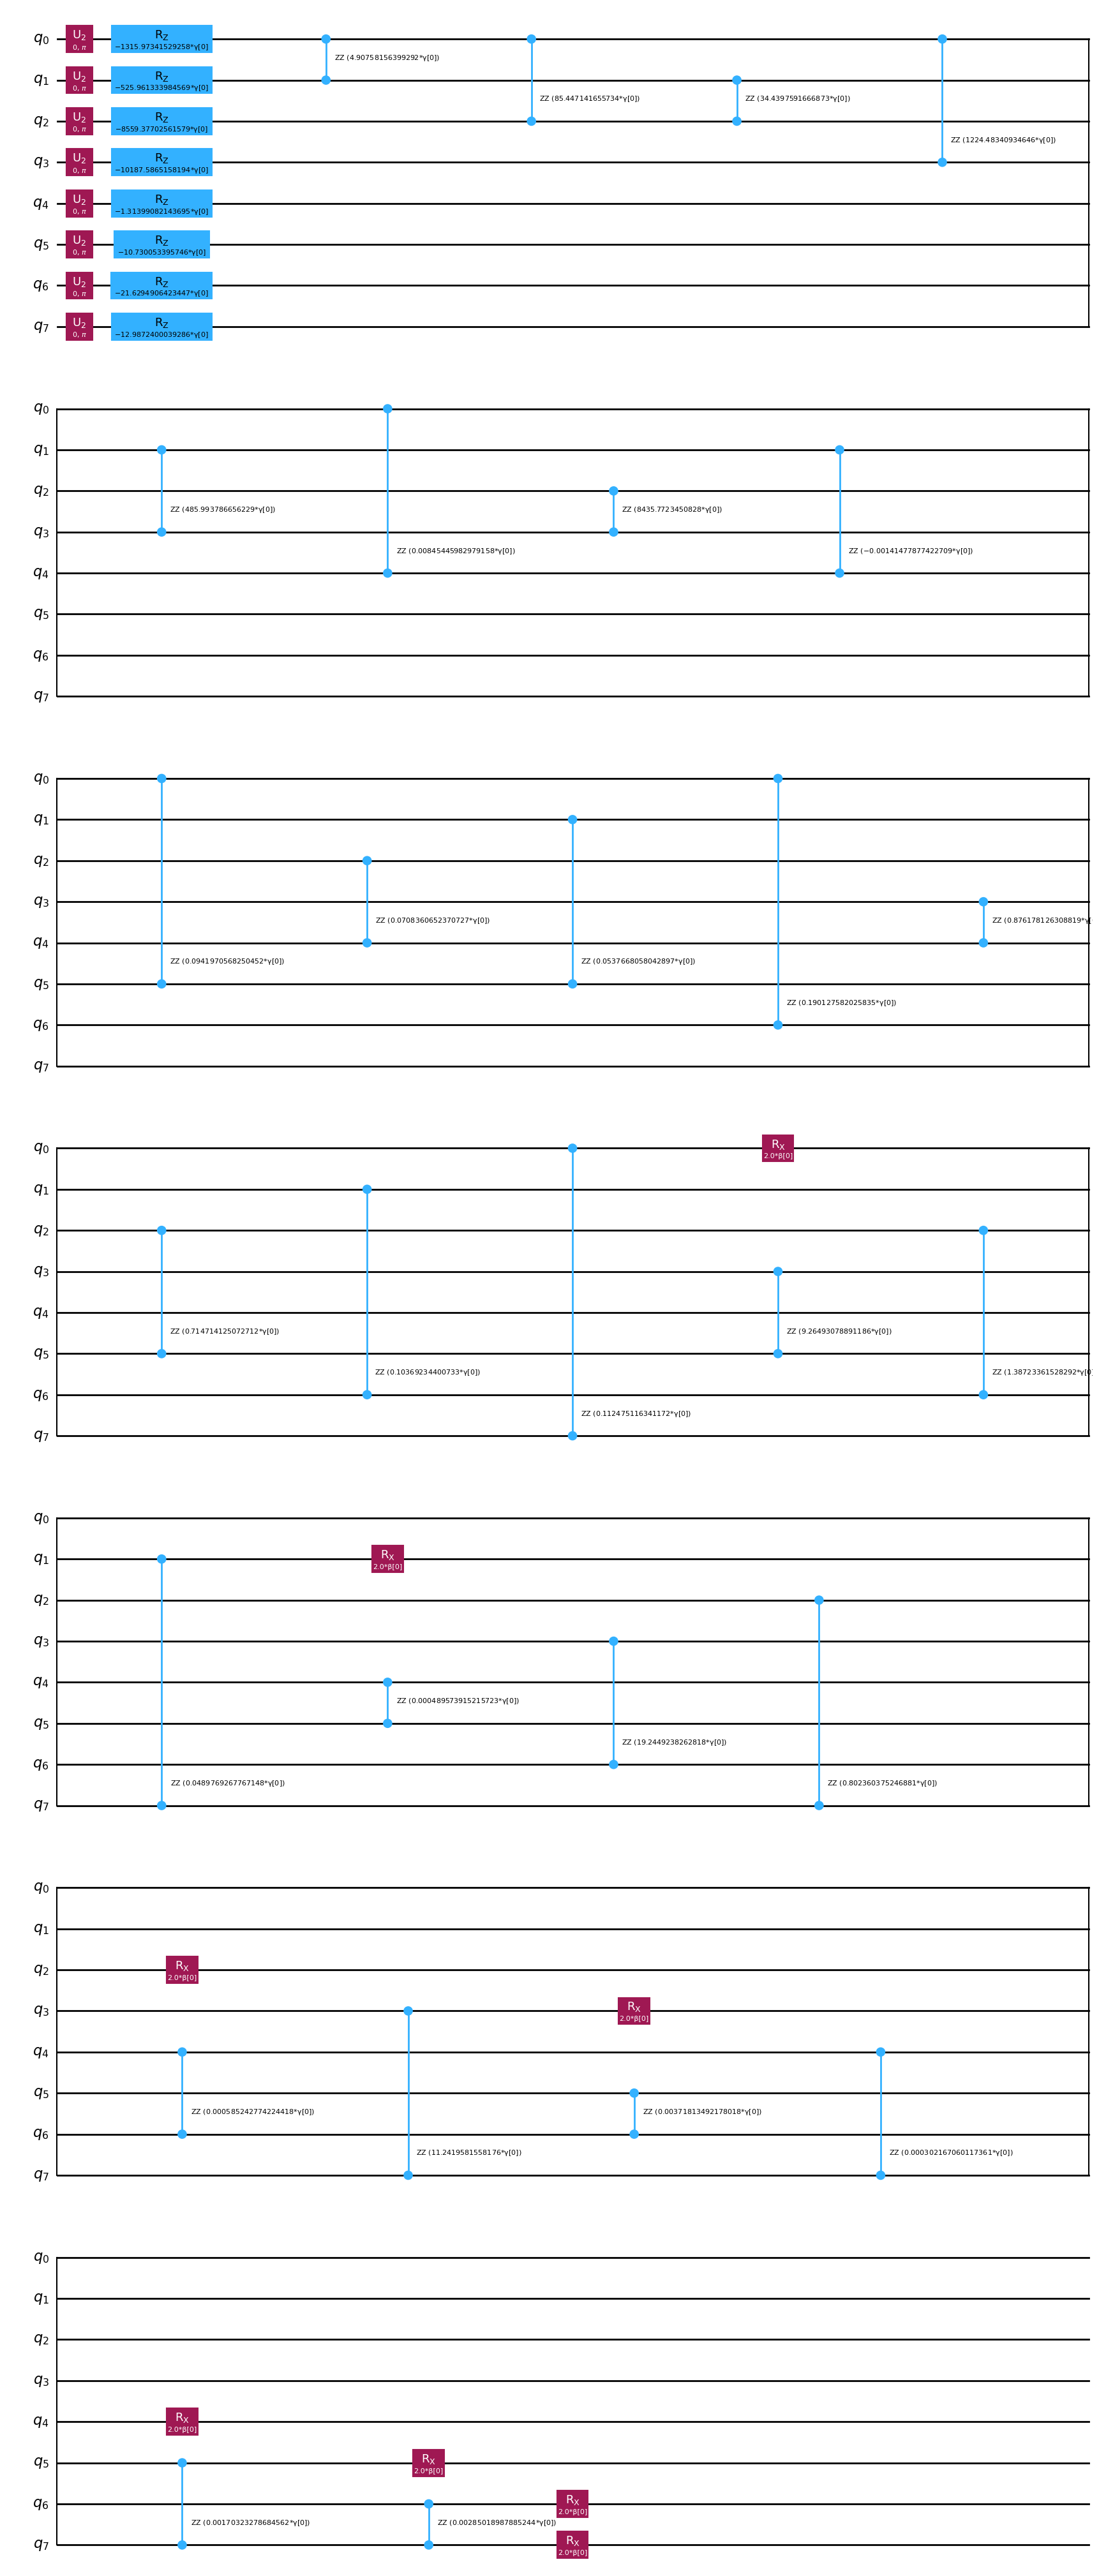

In [80]:
ansatz = QAOAAnsatz(hamiltonian, reps=1)

ansatz.decompose(reps=2).draw(output="mpl", style="iqp")